check working dir

In [62]:
import os
print(os.getcwd())

/home/ayan/work/MachineLearning/FinalProject/src


load clean data into a data frame

In [63]:
%pip install pandas
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


In [64]:
df = pd.read_csv("../data/clean/education_career_success_clean.csv")
df.head()
df['Career_Satisfaction'].value_counts()

Career_Satisfaction
10    524
8     522
9     511
7     508
4     506
2     497
5     497
3     483
6     483
1     469
Name: count, dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       5000 non-null   object 
 1   Age                              5000 non-null   int64  
 2   High_School_GPA                  5000 non-null   float64
 3   SAT_Score                        5000 non-null   int64  
 4   University_Ranking               5000 non-null   int64  
 5   University_GPA                   5000 non-null   float64
 6   Internships_Completed            5000 non-null   int64  
 7   Projects_Completed               5000 non-null   int64  
 8   Certifications                   5000 non-null   int64  
 9   Soft_Skills_Score                5000 non-null   int64  
 10  Networking_Score                 5000 non-null   int64  
 11  Job_Offers                       5000 non-null   int64  
 12  Starting_Salary     

our target vairable is 'job_offers'and 'student_ID' is an unique identifier so we will not include them in our model. Also for the variables we only need N-1 in our model. So we will also drop 'Gender_other' and 'Field_of_study_medicine.

We will also run a correlation analysis with the predictor variables to see if any of them are highly correlated. If they are we will drop one of them.

Job_Offers
2    856
0    848
5    843
3    826
1    823
4    804
Name: count, dtype: int64
Note: you may need to restart the kernel to use updated packages.


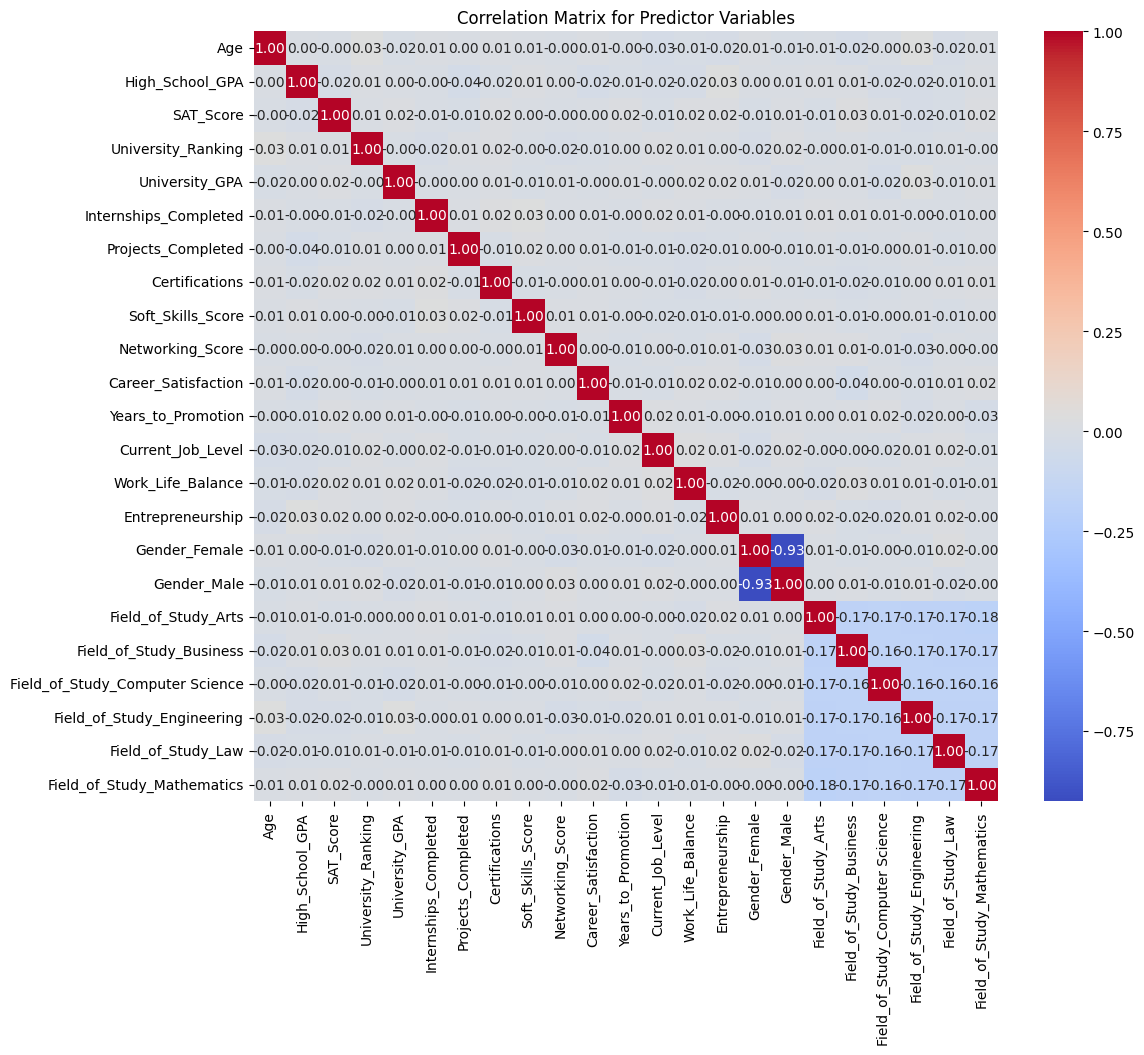

In [ ]:
df_copy = df.copy()
print(df_copy['Job_Offers'].value_counts())
# setting the target variable as its own df
y = df_copy['Job_Offers']
X = df_copy.drop(columns=['Student_ID','Job_Offers','Gender_Other','Field_of_Study_Medicine'])
# we will also plot the correlation matrix
%pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Predictor Variables')
plt.show()


none of the variables are highly correlated. So we will keep all of them in our model for now. This means there is low chance of multicollinearity. If we had more predictor variables we could have also ran a feature selection step using a random forest model to see which variables are most important. But we will not do that here as we have a small number of predictor variables.

Next we will split the data into a training, validation and test set. we will use 60% of the data for trainingm 20% for validation and 20% for testing. Since we are going to use a random forest model we will not need to scale the data. We will also set a random seed for reproducibility.

In [67]:
%pip install scikit-learn
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.


In [68]:
# first we will split into training and validation set - this will be 20% test set and 80% for training + validation
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# further split the training + validation into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 3000
Validation set size: 1000
Test set size: 1000


now that most of the pre processing and splitting is done we will run a MLR (multiple linear regression) 
1) train the model of the training set

In [72]:
from sklearn.feature_selection import SelectFromModel
# Fit a random forest for feature importances
feature_selector = SelectFromModel(RandomForestRegressor(random_state=42), threshold="median")
feature_selector.fit(X_train, y_train)

selected_features = X_train.columns[feature_selector.get_support()]
print("Selected features:", list(selected_features))

# Transform all splits
X_train_selected = feature_selector.transform(X_train)
X_val_selected = feature_selector.transform(X_val)
X_test_selected = feature_selector.transform(X_test)



# train the model on the traoining set 
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor( n_estimators=100,random_state=42)
reg.fit(X_train_selected, y_train)




Selected features: ['Age', 'High_School_GPA', 'SAT_Score', 'University_Ranking', 'University_GPA', 'Internships_Completed', 'Projects_Completed', 'Certifications', 'Soft_Skills_Score', 'Networking_Score', 'Career_Satisfaction', 'Work_Life_Balance']


RandomForestRegressor(random_state=42)

2) make predictions on the validation set and look at goodness of fit metrics (R^2, RMSE, MAE)


In [74]:
# preditc on the validation set
y_val_pred = reg.predict(X_val_selected)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# calculate the MAE, MSE and R2 score
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")






MAE: 1.5224000000000002
MSE: 3.0785752000000004
R2: -0.016710904152114736
